In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

In [65]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['url', 'shares', 'timedelta'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)
# Total variables I dropped
total_dropped = 0

In [66]:
# Using Linear Regression as a base model to judge error 
base_model = LinearRegression().fit(X_train, y_train)
pred = base_model.predict(X_test)
print(mean_absolute_error(y_test, pred))
base_model_mae = 2947.18999587914

2947.18999588876


Text(0, 0.5, 'predictions')

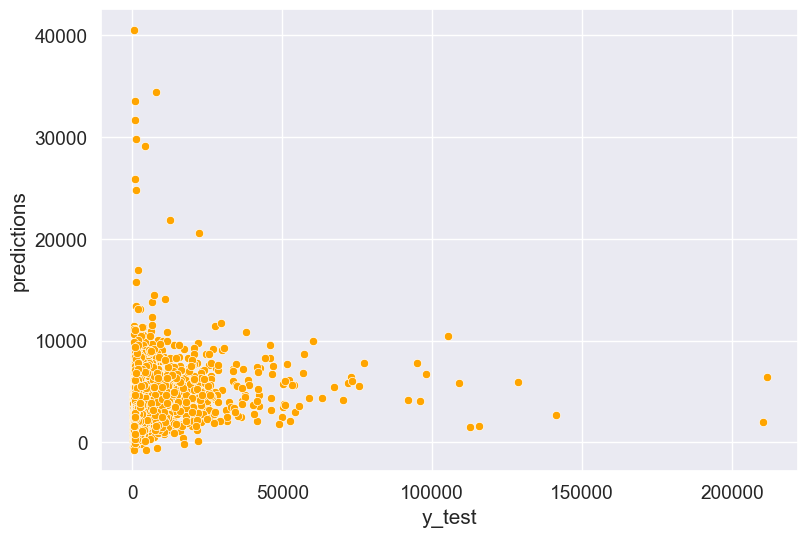

In [67]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = y_test, y=pred,color = 'orange')
plt.xlabel('y_test')
plt.ylabel('predictions')

# Data Visualization to see if any predictors or the response is skewed

<Axes: xlabel='shares', ylabel='Count'>

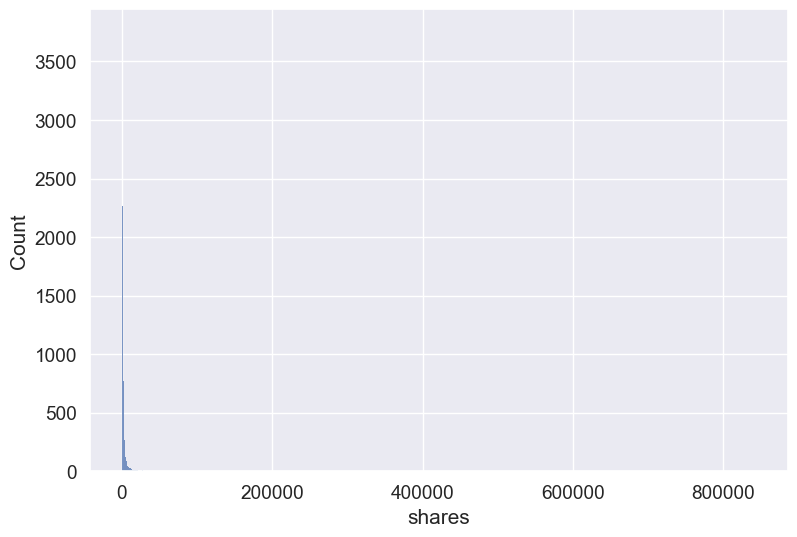

In [68]:
# As you can see the response variable is extremely skewed and has some extreme outliers in its data points.
# Therefore using a log transformation on the predictor is likely to be very helpful
sns.histplot(data.shares)

In [69]:
print(data.shares.mean())
data.shares.std()

3395.3801836343455


11626.950748651712

<Axes: xlabel='shares', ylabel='Count'>

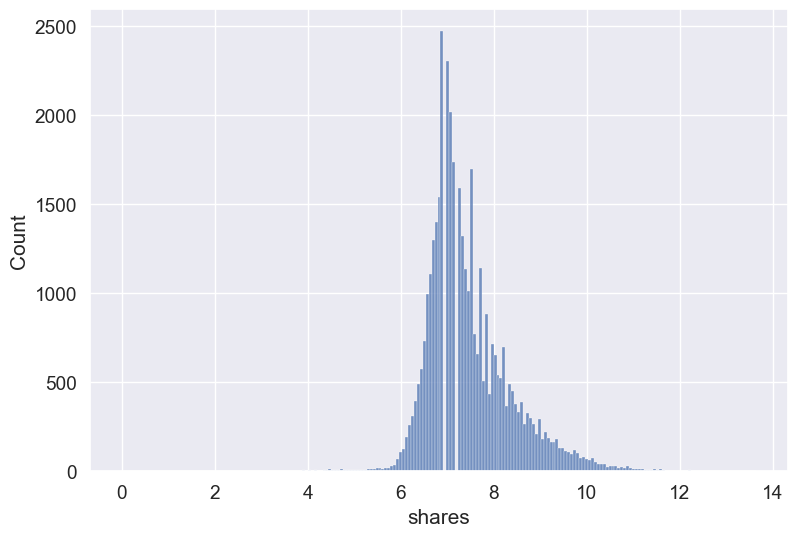

In [70]:
# Scaling with a log transformation looks extremely helpful, and thus looks like something we must do in all our models
# to assist with model prediction
sns.histplot(np.log(data.shares))
# None of the data points are incorrect because they were directly taken from the source and were hard data

In [71]:
# Testing fit after adjusting for outliers in data
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
print('diff between base_model and transformed response model is {}', base_model_mae - mean_absolute_error(y_test, np.exp(pred)))
# Accuracy gets better for MAE with scaling, so will do from now on
mean_absolute_error(y_test, np.exp(pred))

diff between base_model and transformed response model is {} 600.5581969469704


2346.6317989321697

In [72]:
# Using Linear Regression as a base model to judge error 
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
print(mean_absolute_error(y_test, np.exp(pred)))
base_model_mae = 2346.6317989298423

2346.6317989321697


In [73]:
# Percent of data.shares that is considered outliers
third = data.shares.quantile(0.75)
first = data.shares.quantile(0.25)
IQR = third - first
num = data.shares.apply(lambda x: True if (x < first - 2*IQR) else True if (x > third + 2*IQR) else False).sum()
num
print(round(num / data.shares.count() * 100, 2))

# Going to investigate which predictors have more than 5% of their data points being outliers
def find_outliers(series):
    third = series.quantile(0.75)
    first = series.quantile(0.25)
    IQR = third - first
    if (series.apply(lambda x: True if (x < first - 2*IQR) else True if (x > third + 2*IQR) else False).sum()) > 1982:
        return True
    else:
        return False
        
data.drop(columns = 'url').loc[:,data.drop(columns = 'url').apply(lambda x: find_outliers(x), axis = 0)].columns

9.31


Index(['n_non_stop_words', 'num_imgs', 'num_videos',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_max_max', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'title_sentiment_polarity', 'shares'],
      dtype='object')

In [74]:
# Many of the above data values are just largely all 0's and 1's for data points, or just have a few extremely huge outliers,
# and as such there would be no use in scaling them

In [75]:
# Dropping any variables with zero variance
dropped1 = X_train.var(numeric_only = True)[X_train.var(numeric_only = True) == 0].index.tolist()
# There are none with zero variance
len(dropped1)

0

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Will remove variables with the highest values of VIF
to_drop = ['weekday_is_monday', 'weekday_is_saturday', 'LDA_00', 'n_unique_tokens', 'n_non_stop_words', 'self_reference_avg_sharess',
          'rate_positive_words']
# The variables right now result in the lowest rmse we can get, all other variable removals increase the rmse
X = add_constant(X_train.drop(columns = to_drop))
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)   

total_dropped += len(to_drop)
# Total variables dropped due to multicollinearity is 9
base_model = LinearRegression().fit(X_train.drop(columns = to_drop), y_train)
pred = base_model.predict(X_test.drop(columns = to_drop))
print('base mae = {}'.format(base_model_mae))
print('new_model mae = {}'.format(mean_absolute_error(y_test, pred)))
print('diff mae = {}'.format(mean_absolute_error(y_test, pred) - base_model_mae))

base mae = 2346.6317989298423
new_model mae = 2944.2887556406804
diff mae = 597.6569567108381


In [77]:
# Since better difference, remove the predictors entirely
X_train.drop(columns = to_drop, inplace = True)
X_test.drop(columns = to_drop, inplace = True)
all_dropped_predictors = []
for x in to_drop:
    all_dropped_predictors.append(x)

In [78]:
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 10) for x in range(0, 11, 1)]
rmses = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [79]:
# based off of the MAES I'm seeing in the dataframe below, we can see that the RMSE generally doesn't rise all that much
# As the correlation decreases. The differences in the MAE show, however, that the correlation we should investigate is somewhere
# within the range of 0.3 - 1.0
rmses

,MAE,correlation,diff_MAE,model,total_dropped
0,2376.217700,0.0,29.585901,LinearRegression(),50.0
1,2366.838762,0.1,20.206963,LinearRegression(),40.0
2,2359.546681,0.2,12.914882,LinearRegression(),34.0
3,2330.523312,0.3,-16.108486,LinearRegression(),24.0
4,2324.640043,0.4,-21.991756,LinearRegression(),21.0
5,2328.696946,0.5,-17.934853,LinearRegression(),15.0
6,2318.411931,0.6,-28.219868,LinearRegression(),10.0
7,2318.400205,0.7,-28.231594,LinearRegression(),10.0
8,2317.661764,0.8,-28.970035,LinearRegression(),4.0
9,2366.003096,0.9,19.371297,LinearRegression(),1.0


In [80]:
# Fine correlation search
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 100) for x in range(30, 90, 5)]
rmses = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [81]:
# When looking at the difference in MAE, we can see that the correlation to aim for when removing predictors is either
# 0.5 - 0.58 or 0.84-1.0. However, given that the difference in MAE spikes and then falls back down again once we reach 15 
# total dropped suggests that there is a variable that is a significant detriment to our model quality that is removed when we 
# go to a correlation of 0.5. Given that the "spike" in MAE is not that much, if that variable does not end up being that
# significant in reducing MAE as we thought, it still wouldn't significantly impact out model.
rmses

# Therefore we will do one more final fine search in the correlation from 0.4 - 0.6 to find the best correlation to choose

,MAE,correlation,diff_MAE,model,total_dropped
0,2330.523312,0.30,-16.108486,LinearRegression(),24.0
1,2329.399771,0.35,-17.232028,LinearRegression(),22.0
2,2324.640043,0.40,-21.991756,LinearRegression(),21.0
3,2321.507984,0.45,-25.123815,LinearRegression(),20.0
4,2328.696946,0.50,-17.934853,LinearRegression(),15.0
5,2328.333511,0.55,-18.298288,LinearRegression(),14.0
6,2318.411931,0.60,-28.219868,LinearRegression(),10.0
7,2318.400205,0.65,-28.231594,LinearRegression(),10.0
8,2318.400205,0.70,-28.231594,LinearRegression(),10.0
9,2317.604593,0.75,-29.027206,LinearRegression(),6.0


In [82]:
# Fine correlation search
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 100) for x in range(60, 83, 1)]
rmses = pd.DataFrame()

new_columns = []
iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    new_columns.append(actual_columns_drop)
    iteration += 1

In [83]:
# We can find that the best correlation to choose to remove variables is 0.72, 0.73, or 0.74
rmses

,MAE,correlation,diff_MAE,model,total_dropped
0,2318.411931,0.60,-28.219868,LinearRegression(),10.0
1,2318.411931,0.61,-28.219868,LinearRegression(),10.0
2,2318.411931,0.62,-28.219868,LinearRegression(),10.0
3,2318.400205,0.63,-28.231594,LinearRegression(),10.0
4,2318.400205,0.64,-28.231594,LinearRegression(),10.0
5,2318.400205,0.65,-28.231594,LinearRegression(),10.0
6,2318.400205,0.66,-28.231594,LinearRegression(),10.0
7,2318.400205,0.67,-28.231594,LinearRegression(),10.0
8,2318.400205,0.68,-28.231594,LinearRegression(),10.0
9,2318.400205,0.69,-28.231594,LinearRegression(),10.0


In [84]:
# Final dataset is this one
X_train.drop(columns = new_columns[13], inplace = True)
X_test.drop(columns = new_columns[13], inplace = True)

In [85]:
y = np.log(y_train)

In [33]:
from hyperopt import hp, tpe, Trials, fmin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

x_train_encoded = X_train.copy()
y_train = y.copy()

# Define the objective function
def objective(params):
    model = RandomForestRegressor(
        **params,
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(model, x_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return -score

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 500)),
    'max_depth': hp.choice('max_depth', range(1, 9)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
}

# Run the optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(best_params)


  0%|                                              | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

  2%|▍                    | 1/50 [00:11<09:44, 11.92s/trial, best loss: 0.830245621351548]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 16%|███▏                | 8/50 [01:37<04:50,  6.92s/trial, best loss: 0.7514719278763666]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 18%|███▌                | 9/50 [01:57<07:25, 10.86s/trial, best loss: 0.7514719278763666]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 20%|███▊               | 10/50 [02:02<06:06,  9.16s/trial, best loss: 0.7514719278763666]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 22%|████▏              | 11/50 [02:15<06:44, 10.37s/trial, best loss: 0.7514719278763666]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 36%|██████▊            | 18/50 [02:47<02:43,  5.10s/trial, best loss: 0.7514719278763666]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 40%|███████▌           | 20/50 [03:18<05:05, 10.17s/trial, best loss: 0.7504273069225461]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 44%|████████▎          | 22/50 [04:12<08:04, 17.32s/trial, best loss: 0.7470142584653516]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 46%|████████▋          | 23/50 [05:12<13:32, 30.08s/trial, best loss: 0.7470142584653516]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 48%|█████████          | 24/50 [05:29<11:23, 26.28s/trial, best loss: 0.7470142584653516]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 50%|█████████▌         | 25/50 [05:43<09:22, 22.52s/trial, best loss: 0.7470142584653516]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 52%|█████████▉         | 26/50 [06:18<10:28, 26.18s/trial, best loss: 0.7470142584653516]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 54%|██████████▊         | 27/50 [07:47<17:15, 45.03s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 56%|███████████▏        | 28/50 [07:50<11:55, 32.54s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 58%|███████████▌        | 29/50 [08:05<09:33, 27.30s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 60%|████████████        | 30/50 [08:12<07:05, 21.25s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 62%|████████████▍       | 31/50 [08:36<07:00, 22.13s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 64%|████████████▊       | 32/50 [08:55<06:17, 20.99s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 66%|█████████████▏      | 33/50 [09:38<07:50, 27.67s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 68%|█████████████▌      | 34/50 [09:48<05:59, 22.48s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 72%|██████████████▍     | 36/50 [09:55<02:57, 12.70s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 74%|██████████████▊     | 37/50 [10:19<03:27, 15.99s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 76%|███████████████▏    | 38/50 [10:35<03:11, 15.96s/trial, best loss: 0.746639488022393]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 82%|███████████████▌   | 41/50 [11:49<02:43, 18.11s/trial, best loss: 0.7465854858080373]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 84%|███████████████▉   | 42/50 [12:12<02:37, 19.69s/trial, best loss: 0.7465854858080373]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 90%|█████████████████  | 45/50 [12:45<01:01, 12.32s/trial, best loss: 0.7465854858080373]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 92%|█████████████████▍ | 46/50 [12:54<00:45, 11.32s/trial, best loss: 0.7465854858080373]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

 98%|██████████████████▌| 49/50 [13:38<00:11, 11.80s/trial, best loss: 0.7465854858080373]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly se

100%|███████████████████| 50/50 [14:04<00:00, 16.88s/trial, best loss: 0.7465854858080373]
{'max_depth': 7, 'max_features': 0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 287}


In [34]:
best_params = {'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 464}
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(x_train_encoded, y_train)

# Then, use the trained model to make predictions on the test set
y_pred = np.exp(model.predict(X_test))

# Calculate the RMSE on the test set
from sklearn.metrics import mean_squared_error
from math import sqrt
mae = mean_absolute_error(y_test, y_pred)  # y_test should be your actual test target values
print("Test MAE: ", mae)

Test MAE:  2288.6203184457313


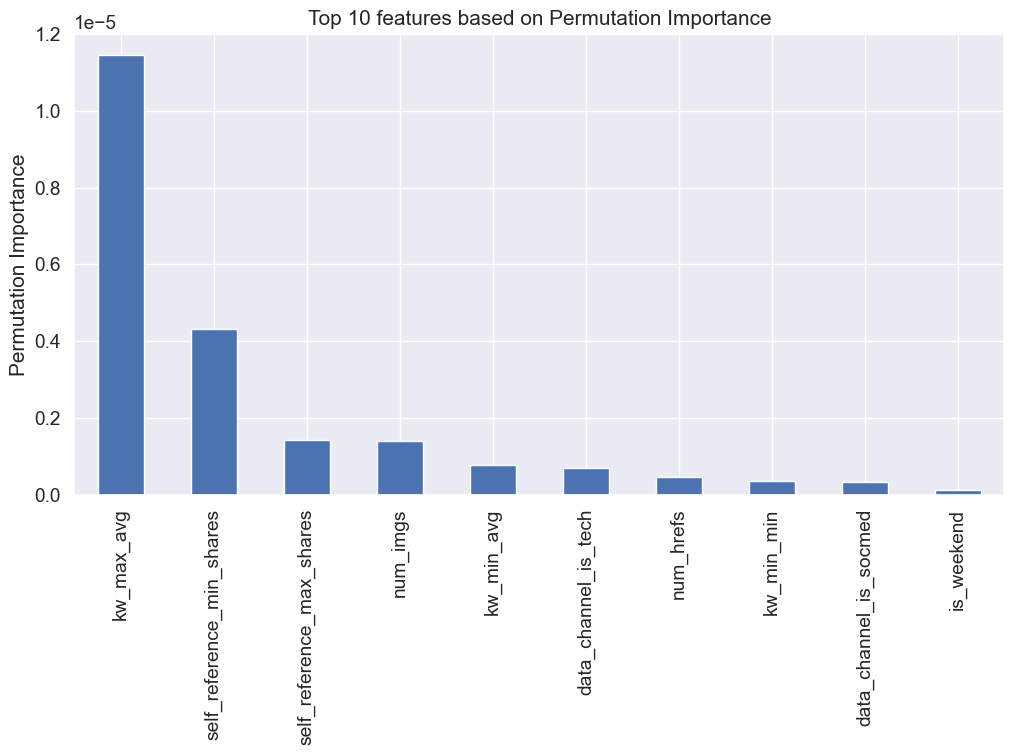

In [46]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute the permutation importances
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create a Series object with the importances
importances = pd.Series(result.importances_mean, index=x_train_encoded.columns)

# Sort the importances and select the top 10
importances = importances.sort_values(ascending=False)[:10]

# Plot the importances
importances.plot(kind='bar', figsize=(12,6))
plt.title('Top 10 features based on Permutation Importance')
plt.ylabel('Permutation Importance')
plt.show()

In [108]:
from hyperopt import hp, tpe, Trials, fmin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the objective function
def objective(params):
    model = RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(model, x_train_encoded, y_train_class, cv=40, scoring='accuracy').mean()
    return -score  # Minimizing -accuracy is equivalent to maximizing accuracy

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 500)),
    'max_depth': hp.choice('max_depth', range(1, 9)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
}

# Run the optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(best_params)

  2%|▍                  | 1/50 [00:42<35:04, 42.95s/trial, best loss: -0.6396654518068452]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

  8%|█▌                 | 4/50 [03:11<32:18, 42.14s/trial, best loss: -0.6575123874304202]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 20%|███▌              | 10/50 [10:29<53:08, 79.72s/trial, best loss: -0.6600032481180022]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 36%|██████▍           | 18/50 [18:28<30:22, 56.95s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 48%|████████▋         | 24/50 [22:51<17:10, 39.63s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 64%|███████████▌      | 32/50 [30:27<16:26, 54.81s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 70%|████████████▌     | 35/50 [33:10<13:34, 54.31s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 78%|██████████████    | 39/50 [35:54<07:47, 42.45s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 86%|███████████████▍  | 43/50 [37:35<03:24, 29.27s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

 92%|████████████████▌ | 46/50 [39:27<01:59, 29.95s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 98%|████████████████▋| 49/50 [50:40<02:30, 150.33s/trial, best loss: -0.6609490236539417]

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(

/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

100%|██████████████████| 50/50 [51:11<00:00, 61.44s/trial, best loss: -0.6609490236539417]
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 336}


In [109]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

best_params = {'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 336}

# Convert your parameters to integer where necessary
# best_params = {
#     'n_estimators': int(best_params['n_estimators']),
#     'max_depth': int(best_params['max_depth']),
#     'min_samples_split': int(best_params['min_samples_split']),
#     'min_samples_leaf': int(best_params['min_samples_leaf']),
# }

y_train = y_train_class.copy()
y_test = y_test_class.copy()

# Initialize the model with the best parameters
model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

# Fit the model
model.fit(X_train, y_train)

# Use the model to make predictions
y_pred = model.predict(X_test)

In [110]:
accuracy_score(y_test,y_pred)

0.6495144406608652